# Pattern Recognition - Project #1

*   **Course:** Pattern Recognition - Fall 2020
*   **Instructor:** [Dr. Morteza Analoui](https://www.scopus.com/authid/detail.uri?authorId=16835800400)
*   **Teaching Assistants:** Mohammad Pourbagheri, Pedram Dadkhah
*   **Student:** [Parsa Abbasi](https://parsa-abbasi.ir/)
*   ***Iran University of Science and Technology (IUST)***




In [ ]:
import re
import time
from random import shuffle
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from tqdm import tqdm
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plt.rcParams['figure.dpi'] = 100
# NLP libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Embeddings
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
# ML algorithms
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
# Hyperparameters tuning
!pip install hypopt
from hypopt import GridSearch
# Metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 1.3MB 7.8MB/s 
     |████████████████████████████████| 1.1MB 33.5MB/s 
     |████████████████████████████████| 2.9MB 54.3MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101034 sha256=c58f085af51203064a5155e00e34be7b60e03dfe7965b1ef6b56431f3d181901
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3140cc32da7aca6ac72408c55c810c0959cf5f6d333a7f258fcea41c9dee2465
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
# PyDrive initializaion to uploading csv files into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Dataset

The dataset we will use in this project contains more than 50000 movie reviews, and it split up into Train, Validation, and Test sets already.

All the movie reviews are long sentences (most of them are longer than 200 words).

Each review was labeled as 1 (positive review) or 0 (negative review).



*   For more information: https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format



In [ ]:
# As the preprocessing of whole data takes a long time, we can use saved preprocessed data files
using_cleaned_data = True

### Getting data from Google Drive

In [ ]:
if using_cleaned_data:
  # Preprocessed dataset files
  train_link = '1E7hTJWo4rUeOifkO-ezSX7S2aRYI3jMh'
  validation_link = '1K0BX0eiimupOmNRCKPIAVTzkdGEx9nr_'
  test_link = '1Da0B24ksG8kstihYf_gYXSjdq66m3ak9'
else:
  # Original dataset
  train_link = '1Rzl9Dat1FAblECENid99dxGEmM72bAGk'
  validation_link = '1gCUFcZg4KgkoW0qERGWDMnPit2wZZPm9'
  test_link = '1uyNkXJAThToQVs9vW87_dQrcngt6btoP'

In [ ]:
# Getting data files and shape them as pandas dataframes
downloaded = drive.CreateFile({'id':train_link}) 
downloaded.GetContentFile('Train.csv')  
train = pd.read_csv('Train.csv')

downloaded = drive.CreateFile({'id':validation_link}) 
downloaded.GetContentFile('Valid.csv')  
valid = pd.read_csv('Valid.csv')

downloaded = drive.CreateFile({'id':test_link}) 
downloaded.GetContentFile('Test.csv')  
test = pd.read_csv('Test.csv')

### Analyzing dataset

In [ ]:
# Getting the number of positive and negative reviews on each data partitions
neg_train_num = train.groupby('label').count().iloc[0]['text']
neg_valid_num = valid.groupby('label').count().iloc[0]['text']
neg_test_num = test.groupby('label').count().iloc[0]['text']
pos_train_num = train.groupby('label').count().iloc[1]['text']
pos_valid_num = valid.groupby('label').count().iloc[1]['text']
pos_test_num = test.groupby('label').count().iloc[1]['text']

In [ ]:
labels = ['Train', 'Validation', 'Test']
positives = [neg_train_num, neg_valid_num, neg_test_num]
negatives = [pos_train_num, pos_valid_num, pos_test_num]

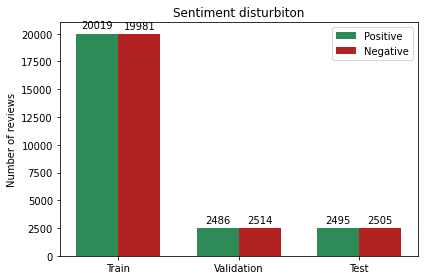

In [ ]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, positives, width, label='Positive', color='seagreen')
rects2 = ax.bar(x + width/2, negatives, width, label='Negative', color='firebrick')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of reviews')
ax.set_title('Sentiment disturbiton')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

The dataset is well balanced, as the plot shows.

### Preparing data

In [ ]:
text_train = train.drop('label', axis=1).iloc[:,0]
y_train = np.asarray(train['label'])
text_valid = valid.drop('label', axis=1).iloc[:,0]
y_valid = np.asarray(valid['label'])
text_test = test.drop('label', axis=1).iloc[:,0]
y_test = np.asarray(test['label'])

## Preprocessing

Preprocessing steps on each data:

1.   Converting to Lowercase
2.   Removing HTML tags
3.   Removing all the special characters
4.   Substituting multiple spaces with a single space
5.   Removing all the stop words, punctuation, numbers, and single characters
6.   Substituting each word with their lemmas


In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Removing HTML tags using Regex
TAG_RE = re.compile(r'<[^>]+>')

def preprocessing(doc):
  # Converting to Lowercase
  doc = doc.lower()
  # Removing HTML tags
  doc = TAG_RE.sub(' ', doc)
  # Removing all the special characters
  doc = re.sub(r'\W', ' ', doc)
  # Substituting multiple spaces with single space
  doc = re.sub(r'\s+', ' ', doc, flags=re.I)
  # Make spacy document object
  doc = nlp(doc)
  # 1) Removing stop words, punctuation, numbers and single characters
  # 2) Substituting each words with their lemmas
  tokens = [token.lemma_ for token in doc if (token.is_stop == False and token.is_punct == False and token.is_digit == False and len(token)>1)]
  # Merge tokens into a string
  cleaned_doc = ' '.join(tokens)
  return cleaned_doc

### Test preprocessing

In [ ]:
text_train[0]

In [ ]:
print(preprocessing(text_train[0]))

### Apply preprocessing on data

As the preprocessing of whole data takes a long time, it's better to do this step just once and save the results for further developments.

In [ ]:
if using_cleaned_data:
  # Just using the cleaned data if we load the preprocessed dataset
  x_train = text_train
  x_valid = text_valid
  x_test = text_test
else:
  # Apply preprocessing on data
  # Training data
  x_train = []
  for doc in tqdm(text_train):
    cleaned_doc = preprocessing(doc)
    x_train.append(cleaned_doc)
  # Validation data
  x_valid = []
  for doc in tqdm(text_valid):
    cleaned_doc = preprocessing(doc)
    x_valid.append(cleaned_doc)
  # Test data
  x_test = []
  for doc in tqdm(text_test):
    cleaned_doc = preprocessing(doc)
    x_test.append(cleaned_doc)
  # Saving preprocessed data as .csv files into google drive
  # Following code need google drive to be mounted
  drive_path = "/content/drive/MyDrive/NLP Datasets/IMDB/Cleaned/"
  pd.DataFrame({'text': x_train, 'label': y_train}).to_csv(drive_path + "Train.csv",index=False)
  pd.DataFrame({'text': x_valid, 'label': y_valid}).to_csv(drive_path + "Valid.csv",index=False)
  pd.DataFrame({'text': x_test, 'label': y_test}).to_csv(drive_path + "Test.csv",index=False)

## Defining metrics

Defining some useful function to evaluate and analyze our models

In [ ]:
# Plot confusion matrix
def plot_cm(clf, x_cf, y_cf):
  metrics.plot_confusion_matrix(clf, x_cf, y_cf, values_format='.0f', cmap="OrRd")

In [ ]:
def plot_roc(clf, x_cf, y_cf):
  metrics.plot_roc_curve(clf, x_cf, y_cf)

In [ ]:
def get_metrics(true_labels, predicted_labels):
  auc = metrics.roc_auc_score(predicted_labels, true_labels)
  accuracy = str(accuracy_score(true_labels, predicted_labels))
  precision = str(precision_score(true_labels, predicted_labels))
  recall = str(recall_score(true_labels, predicted_labels))
  fscore = str(f1_score(true_labels, predicted_labels))
  result = {'accuracy':accuracy, 'auc': auc, 'precision': precision, 'recall': recall, 'fscore':fscore}
  return result

In [ ]:
# Getting linear and rbf gridsearch results and sorting based on accuracy
def join_kernel_results(k1, k2):
  results = k1 + k2
  results = sorted(results, key=lambda x: x[1], reverse=True)
  return results

## Bert Document Transformer (Embedding)

We will use the sentence-transformers library, to get a Bert embedding for each of our documents.

The transformer that will be used here is *'bert-base-nli-stsb-mean-tokens'* with the following properties:


*   Base model: *bert-base-uncased*
*   Pooling method: *Mean Pooling*
*   Training data: *NLI+STSb*
*   Speed (Sent. / Sec on V100 GPU): *2300*



In [ ]:
bert_model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

100%|██████████| 405M/405M [00:23<00:00, 17.1MB/s]


In [ ]:
print("Max Sequence Length:", bert_model.max_seq_length)

Max Sequence Length: 128


In [ ]:
#Change the length to 512
bert_model.max_seq_length = 512

print("Max Sequence Length:", bert_model.max_seq_length)

Max Sequence Length: 512


In [ ]:
bert_x_train = bert_model.encode(x_train, show_progress_bar=True)

In [ ]:
bert_x_valid = bert_model.encode(x_valid, show_progress_bar=True)

In [ ]:
bert_x_test = bert_model.encode(x_test, show_progress_bar=True)

## Naive Bayes (NB)

### NB with Bag of Words vectorization

In [ ]:
nb_count_vect = CountVectorizer(lowercase=True)
nb_x_train_counts = nb_count_vect.fit_transform(x_train)

In [ ]:
nb_x_valid_counts = nb_count_vect.transform(x_valid)
nb_x_test_counts = nb_count_vect.transform(x_test)

In [ ]:
nb_bow_clf = MultinomialNB()
nb_bow_clf.fit(nb_x_train_counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_bow_pred = nb_bow_clf.predict(nb_x_test_counts)

In [ ]:
nb_bow_results = get_metrics(y_test, nb_bow_pred)
print(nb_bow_results)

{'accuracy': '0.8602', 'auc': 0.8605106403420282, 'precision': '0.8716049382716049', 'recall': '0.8455089820359282', 'fscore': '0.8583586626139817'}


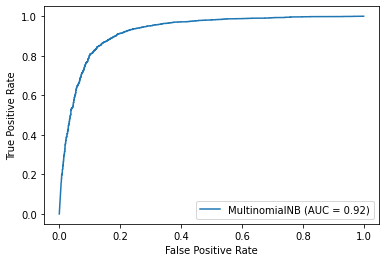

In [ ]:
plot_roc(nb_bow_clf, nb_x_test_counts, y_test)

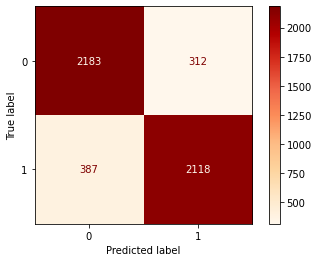

In [ ]:
plot_cm(nb_bow_clf, nb_x_test_counts, y_test)

### NB with Tf-idf vectorization

In [ ]:
nb_tfidf_transformer = TfidfTransformer()
nb_x_train_tfidf = nb_tfidf_transformer.fit_transform(nb_x_train_counts)

In [ ]:
nb_x_valid_tfidf  = nb_tfidf_transformer.transform(nb_x_valid_counts)
nb_x_test_tfidf = nb_tfidf_transformer.transform(nb_x_test_counts)

In [ ]:
nb_tfidf_clf = MultinomialNB()
nb_tfidf_clf.fit(nb_x_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_tfidf_pred = nb_tfidf_clf.predict(nb_x_test_tfidf)

In [ ]:
nb_tfidf_results = get_metrics(y_test, nb_tfidf_pred)
print(nb_tfidf_results)

{'accuracy': '0.8626', 'auc': 0.862741209663944, 'precision': '0.8704156479217604', 'recall': '0.8526946107784431', 'fscore': '0.8614640048396854'}


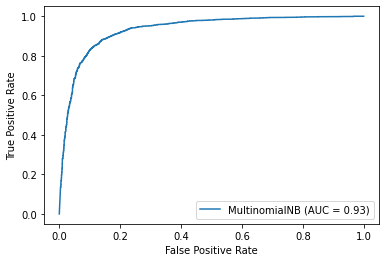

In [ ]:
plot_roc(nb_tfidf_clf, nb_x_test_counts, y_test)

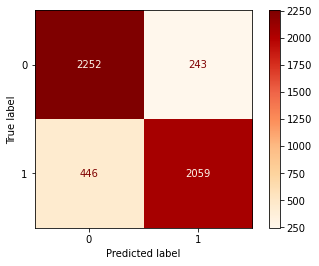

In [ ]:
plot_cm(nb_tfidf_clf, nb_x_test_counts, y_test)

### NB with Bert embedding

In [ ]:
nb_bert_clf = GaussianNB()
nb_bert_clf.fit(bert_x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
nb_bert_pred = nb_bert_clf.predict(bert_x_test)

In [ ]:
nb_bert_results = get_metrics(y_test, nb_bert_pred)
print(nb_bert_results)

{'accuracy': '0.7688', 'auc': 0.7692441308843985, 'precision': '0.7806908031627132', 'recall': '0.7489021956087825', 'fscore': '0.7644661776691116'}


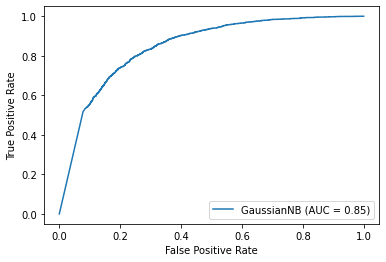

In [ ]:
plot_roc(nb_bert_clf, bert_x_test, y_test)

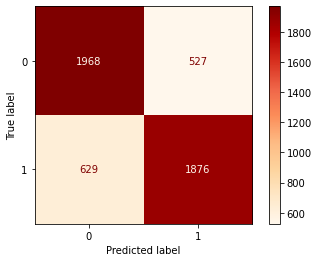

In [ ]:
plot_cm(nb_bert_clf, bert_x_test, y_test)

## Support Vector Machine (SVM)

### SVM with Bag of words vectorization

In grid search we are tuning three major parameters as following [[1]](https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/):


*   **Kernel:** The main function of the kernel is to take low dimensional input space and transform it into a higher-dimensional space. It is mostly useful in non-linear separation problem.
*   **C:** Penalty parameter. When C is high it will classify all the data points correctly, also there is a chance to overfit.
*   **Gamma:** when gamma is higher, nearby points will have high influence; low gamma means far away points also be considered to get the decision boundary. 



In [ ]:
count_vect = CountVectorizer(max_features=768, lowercase=True)
x_train_counts = count_vect.fit_transform(x_train)

In [ ]:
x_valid_counts = count_vect.transform(x_valid)
x_test_counts = count_vect.transform(x_test)

In [ ]:
# LinearSVC is much faster than SVC, so I splitted up the linear and rbf kernels
linear_svm_bow_param = [{'C': [1, 10, 100]}]
linear_svm_bow_grid = GridSearch(model = svm.LinearSVC(max_iter=10000), param_grid = linear_svm_bow_param)
linear_svm_bow_grid.fit(x_train_counts, y_train, x_valid_counts, y_valid)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 33%|███▎      | 1/3 [01:56<03:53, 116.55s/it]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 3/3 [03:30<00:00, 70.32s/it]


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [ ]:
rbf_svm_bow_param = [{'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}]
rbf_svm_bow_grid = GridSearch(model = svm.SVC(max_iter=10000), param_grid = rbf_svm_bow_param)
rbf_svm_bow_grid.fit(x_train_counts, y_train, x_valid_counts, y_valid)

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
100%|██████████| 9/9 [43:42<00:00, 291.43s/it]


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=10000, probability=False, random_state=0, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
linear_svm_bow_pr = linear_svm_bow_grid.get_param_scores()
rbf_svm_bow_pr = rbf_svm_bow_grid.get_param_scores()
join_kernel_results(linear_svm_bow_pr, rbf_svm_bow_pr)

[({'C': 1}, 0.8556),
 ({'C': 10}, 0.8544),
 ({'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, 0.8448),
 ({'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8446),
 ({'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.843),
 ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.8414),
 ({'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.8388),
 ({'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8338),
 ({'C': 100}, 0.8274),
 ({'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8056),
 ({'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, 0.706),
 ({'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.513)]

In [160]:
# Choose the best model based on gridsearch results
svm_bow_best_model = None
if linear_svm_bow_pr[0][1] > rbf_svm_bow_pr[0][1]:
  svm_bow_best_model = linear_svm_bow_grid.best_estimator_
else:
  svm_bow_best_model = rbf_svm_bow_grid.best_estimator_

In [161]:
svm_bow_pred = svm_bow_best_model.predict(x_test_counts)

In [162]:
svm_bow_results = get_metrics(y_test, svm_bow_pred)
print(svm_bow_results)

{'accuracy': '0.8546', 'auc': 0.8550851944242903, 'precision': '0.8424499229583975', 'recall': '0.8730538922155688', 'fscore': '0.8574789257008428'}


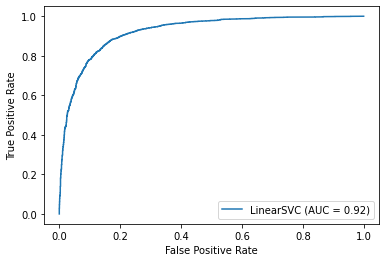

In [ ]:
plot_roc(svm_bow_best_model, x_test_counts, y_test)

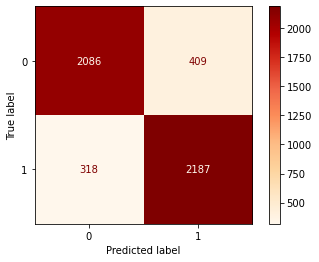

In [ ]:
plot_cm(svm_bow_best_model, x_test_counts, y_test)

### SVM with Tf-idf vectorization

In [ ]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
x_valid_tfidf  = tfidf_transformer.transform(x_valid_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

In [ ]:
# LinearSVC is much faster than SVC, so I splitted up the linear and rbf kernels
linear_svm_tfidf_param = [{'C': [1, 10, 100]}]
linear_svm_tfidf_grid = GridSearch(model = svm.LinearSVC(max_iter=10000), param_grid = linear_svm_tfidf_param)
linear_svm_tfidf_grid.fit(x_train_tfidf, y_train, x_valid_tfidf, y_valid)

100%|██████████| 3/3 [00:50<00:00, 16.78s/it]


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [ ]:
rbf_svm_tfidf_param = [{'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}]
rbf_svm_tfidf_grid = GridSearch(model = svm.SVC(max_iter=10000), param_grid = rbf_svm_tfidf_param)
rbf_svm_tfidf_grid.fit(x_train_tfidf, y_train, x_valid_tfidf, y_valid)

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
100%|██████████| 9/9 [53:46<00:00, 358.47s/it]


SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=10000, probability=False, random_state=0, shrinking=True,
    tol=0.001, verbose=False)

In [144]:
linear_svm_tfidf_pr = linear_svm_tfidf_grid.get_param_scores()
rbf_svm_tfidf_pr = rbf_svm_tfidf_grid.get_param_scores()
join_kernel_results(linear_svm_tfidf_pr, rbf_svm_tfidf_pr)

[({'C': 1}, 0.8524),
 ({'C': 10}, 0.852),
 ({'C': 100}, 0.8516),
 ({'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8508),
 ({'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, 0.8504),
 ({'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, 0.85),
 ({'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.8312),
 ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.8312),
 ({'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8288),
 ({'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, 0.6906),
 ({'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.6884),
 ({'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.5938)]

In [145]:
# Choose the best model based on gridsearch results
svm_tfidf_best_model = None
if linear_svm_tfidf_pr[0][1] > rbf_svm_tfidf_pr[0][1]:
  svm_tfidf_best_model = linear_svm_tfidf_grid.best_estimator_
else:
  svm_tfidf_best_model = rbf_svm_tfidf_grid.best_estimator_

In [146]:
svm_tfidf_pred = svm_tfidf_best_model.predict(x_test_tfidf)

In [147]:
svm_tfidf_results = get_metrics(y_test, svm_tfidf_pred)
print(svm_tfidf_results)

{'accuracy': '0.8554', 'auc': 0.8557499300046962, 'precision': '0.8450813323005422', 'recall': '0.871057884231537', 'fscore': '0.8578730096323964'}


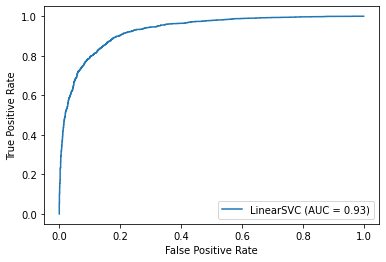

In [148]:
plot_roc(svm_tfidf_best_model, x_test_tfidf, y_test)

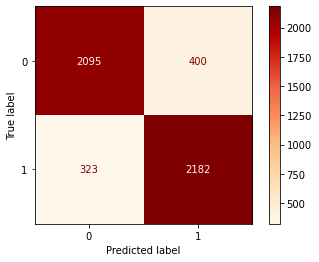

In [149]:
plot_cm(svm_tfidf_best_model, x_test_tfidf, y_test)

### SVM with Bert embedding

In [150]:
# LinearSVC is much faster than SVC, so I splitted up the linear and rbf kernels
linear_svm_bert_param = [{'C': [1, 10, 100]}]
linear_svm_bert_grid = GridSearch(model = svm.LinearSVC(max_iter=10000), param_grid = linear_svm_bert_param)
linear_svm_bert_grid.fit(bert_x_train, y_train, bert_x_valid, y_valid)

 33%|███▎      | 1/3 [08:29<16:59, 509.70s/it]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 67%|██████▋   | 2/3 [18:17<08:53, 533.24s/it]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 3/3 [24:52<00:00, 497.54s/it]


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [151]:
rbf_svm_bert_param = [{'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}]
rbf_svm_bert_grid = GridSearch(model = svm.SVC(max_iter=10000), param_grid = rbf_svm_bert_param)
rbf_svm_bert_grid.fit(bert_x_train, y_train, bert_x_valid, y_valid)

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 22%|██▏       | 2/9 [19:55<1:32:30, 792.88s/it] /usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=10000, probability=False, random_state=0, shrinking=True,
    tol=0.001, verbose=False)

In [152]:
linear_svm_bert_pr = linear_svm_bert_grid.get_param_scores()
rbf_svm_bert_pr = rbf_svm_bert_grid.get_param_scores()
join_kernel_results(linear_svm_bert_pr, rbf_svm_bert_pr)

[({'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8486),
 ({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.8456),
 ({'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8422),
 ({'C': 1}, 0.8412),
 ({'C': 10}, 0.8398),
 ({'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.8396),
 ({'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8316),
 ({'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.8314),
 ({'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, 0.8314),
 ({'C': 100}, 0.8068),
 ({'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, 0.794),
 ({'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, 0.6488)]

In [153]:
# Choose the best model based on gridsearch results
svm_bert_best_model = None
if linear_svm_bert_pr[0][1] > rbf_svm_bert_pr[0][1]:
  svm_bert_best_model = linear_svm_bert_grid.best_estimator_
else:
  svm_bert_best_model = rbf_svm_bert_grid.best_estimator_

In [154]:
svm_bert_pred = svm_bert_best_model.predict(bert_x_test)

In [155]:
svm_bert_results = get_metrics(y_test, svm_bert_pred)
print(svm_bert_results)

{'accuracy': '0.8474', 'auc': 0.847551987685341, 'precision': '0.8407668231611893', 'recall': '0.8578842315369262', 'fscore': '0.8492392807745506'}


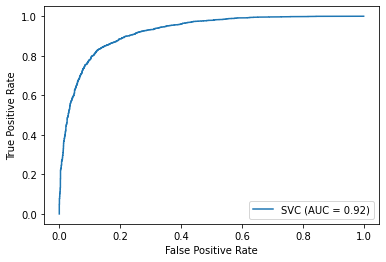

In [156]:
plot_roc(svm_bert_best_model, bert_x_test, y_test)

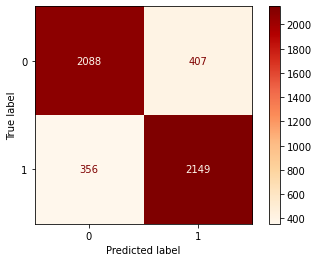

In [157]:
plot_cm(svm_bert_best_model, bert_x_test, y_test)